In [4]:
from google.colab import files
files.upload()  # Upload kaggle.json when prompted

!mkdir -p ~/.kaggle
!cp kaggle.json ~/.kaggle/
!chmod 600 ~/.kaggle/kaggle.json


Saving kaggle.json to kaggle.json


In [5]:
!kaggle datasets download -d puneet6060/intel-image-classification
!unzip intel-image-classification.zip -d intel_data


Streaming output truncated to the last 5000 lines.
  inflating: intel_data/seg_train/seg_train/mountain/7506.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7537.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7539.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7551.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7560.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7565.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7578.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7581.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7586.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7647.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7652.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7654.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7662.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/767.jpg  
  inflating: intel_data/seg_train/seg_train/mountain/7

In [35]:
import torch
from torch.utils.data import DataLoader
from torchvision import datasets, transforms

# Define transforms
transform = transforms.Compose([
    transforms.Resize((150, 150)),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5))  # 3-channel normalize
])

# Corrected paths (one level deeper)
train_data = datasets.ImageFolder("intel_data/seg_train/seg_train", transform=transform)
test_data  = datasets.ImageFolder("intel_data/seg_test/seg_test", transform=transform)

# Create dataloaders
trainloader = DataLoader(train_data, batch_size=32, shuffle=True)
testloader  = DataLoader(test_data, batch_size=32, shuffle=False)

# Print available classes
print("Classes:", train_data.classes)



Classes: ['buildings', 'forest', 'glacier', 'mountain', 'sea', 'street']


In [28]:
import torch
print(torch.cuda.is_available())


True


In [36]:
import torch.nn as nn
import torch.nn.functional as F
import torch.optim as optim

class Net(nn.Module):
    def __init__(self):
        super().__init__()
        self.conv1 = nn.Conv2d(3, 32, 3, padding=1)
        self.pool = nn.MaxPool2d(2, 2)
        self.conv2 = nn.Conv2d(32, 64, 3, padding=1)
        self.fc1 = nn.Linear(64 * 37 * 37, 512)
        self.fc2 = nn.Linear(512, 6)  # 6 classes

    def forward(self, x):
        x = self.pool(F.relu(self.conv1(x)))
        x = self.pool(F.relu(self.conv2(x)))
        x = x.view(x.size(0), -1)  # safer flattening
        x = F.relu(self.fc1(x))
        x = self.fc2(x)
        return x

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")
net = Net().to(device)

criterion = nn.CrossEntropyLoss()
optimizer = optim.Adam(net.parameters(), lr=0.001)

# Training loop
for epoch in range(10):  # train longer (10+ epochs)
    net.train()
    running_loss = 0.0
    for images, labels in trainloader:
        images, labels = images.to(device), labels.to(device)

        optimizer.zero_grad()
        outputs = net(images)
        loss = criterion(outputs, labels)
        loss.backward()
        optimizer.step()

        running_loss += loss.item()

    # Validation step
    net.eval()
    correct, total = 0, 0
    with torch.no_grad():
        for images, labels in testloader:
            images, labels = images.to(device), labels.to(device)
            outputs = net(images)
            _, predicted = torch.max(outputs, 1)
            total += labels.size(0)
            correct += (predicted == labels).sum().item()

    acc = 100 * correct / total
    print(f"Epoch {epoch+1}, Loss: {running_loss/len(trainloader):.4f}, Val Acc: {acc:.2f}%")

print("Training Finished ✅")



Epoch 1, Loss: 1.1405, Val Acc: 69.30%
Epoch 2, Loss: 0.7265, Val Acc: 74.33%
Epoch 3, Loss: 0.5340, Val Acc: 77.87%
Epoch 4, Loss: 0.3691, Val Acc: 79.13%
Epoch 5, Loss: 0.2181, Val Acc: 77.60%
Epoch 6, Loss: 0.0995, Val Acc: 78.40%
Epoch 7, Loss: 0.0497, Val Acc: 78.57%
Epoch 8, Loss: 0.0386, Val Acc: 75.97%
Epoch 9, Loss: 0.0551, Val Acc: 78.87%
Epoch 10, Loss: 0.0408, Val Acc: 76.87%
Training Finished ✅


In [37]:
# Final test accuracy
net.eval()
correct, total = 0, 0
all_preds, all_labels = [], []

with torch.no_grad():
    for images, labels in testloader:
        images, labels = images.to(device), labels.to(device)
        outputs = net(images)
        _, predicted = torch.max(outputs, 1)
        total += labels.size(0)
        correct += (predicted == labels).sum().item()
        all_preds.extend(predicted.cpu().numpy())
        all_labels.extend(labels.cpu().numpy())

print(f"Final Test Accuracy: {100 * correct / total:.2f}%")

# Show a few predictions
classes = train_data.classes
for i in range(10):
    print(f"Pred: {classes[all_preds[i]]}, True: {classes[all_labels[i]]}")



Final Test Accuracy: 76.87%
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings
Pred: buildings, True: buildings


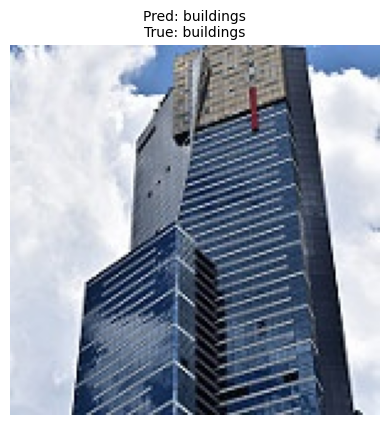

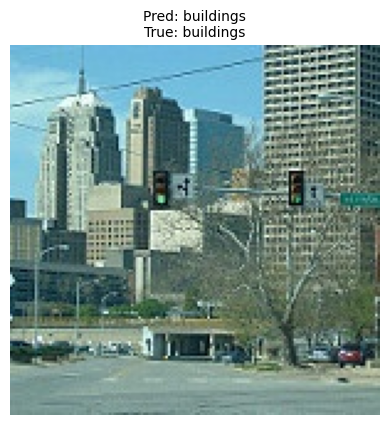

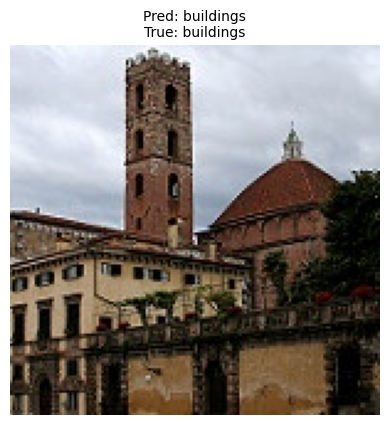

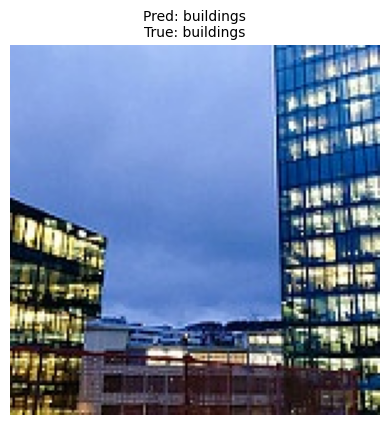

In [38]:
import matplotlib.pyplot as plt
import numpy as np

# Function to show image
def imshow(img, title):
    img = img.cpu().numpy().transpose((1, 2, 0))
    img = img * 0.5 + 0.5   # unnormalize (since we used Normalize((0.5,0.5,0.5),...))
    plt.imshow(img)
    plt.title(title, fontsize=10)
    plt.axis('off')
    plt.show()

# Get one batch from testloader
dataiter = iter(testloader)
images, labels = next(dataiter)
images, labels = images.to(device), labels.to(device)

# Predictions
net.eval()
with torch.no_grad():
    outputs = net(images[:4])
    _, preds = torch.max(outputs, 1)

# Show first 4 images with prediction + true label
for i in range(4):
    imshow(
        images[i],
        f"Pred: {train_data.classes[preds[i]]}\nTrue: {train_data.classes[labels[i]]}"
    )


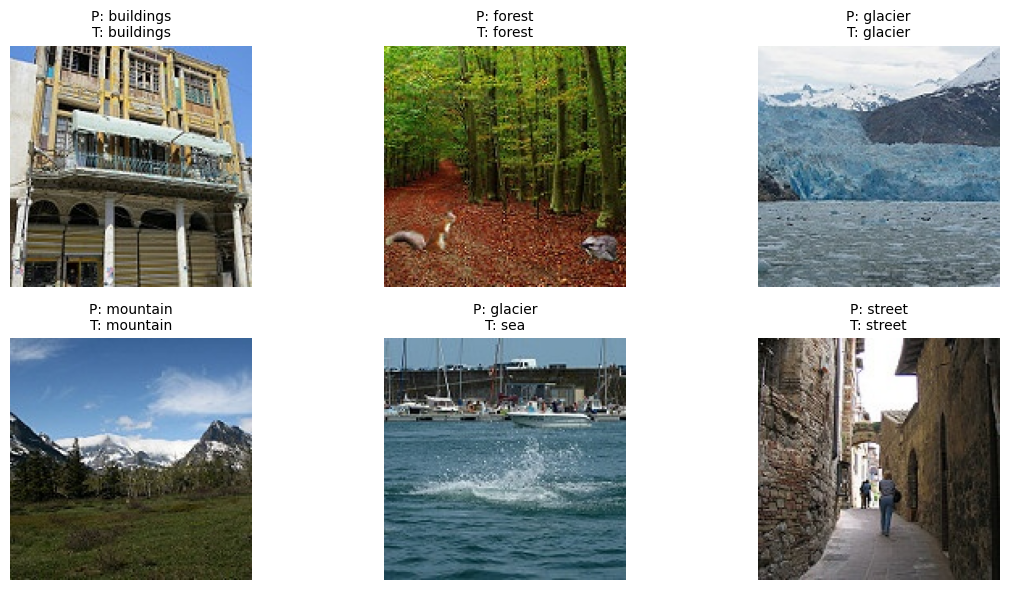

In [51]:
import torch
from torch.utils.data import DataLoader
import matplotlib.pyplot as plt
import numpy as np
import random

# DataLoader (shuffle True for random selection)
testloader = DataLoader(test_data, batch_size=64, shuffle=False)

# Function to show images
def imshow_grid(images, labels, preds, classes):
    num = len(images)
    plt.figure(figsize=(12, 6))
    for i in range(num):
        img = images[i].cpu().numpy().transpose((1, 2, 0))
        img = img * 0.5 + 0.5  # unnormalize
        plt.subplot(2, 3, i+1)
        plt.imshow(img)
        plt.title(f"P: {classes[preds[i]]}\nT: {classes[labels[i]]}", fontsize=10)
        plt.axis("off")
    plt.tight_layout()
    plt.show()

# Group indices of test images by class
class_to_indices = {i: [] for i in range(len(train_data.classes))}
for idx, (_, label) in enumerate(test_data):
    class_to_indices[label].append(idx)

# Pick one random image per class
images, labels = [], []
for cls, indices in class_to_indices.items():
    idx = random.choice(indices)
    img, label = test_data[idx]
    images.append(img)
    labels.append(label)

images = torch.stack(images).to(device)
labels = torch.tensor(labels).to(device)

# Get predictions
net.eval()
with torch.no_grad():
    outputs = net(images)
    _, preds = torch.max(outputs, 1)

# Visualize
imshow_grid(images, labels, preds, train_data.classes)


